In [3]:
pip install networkx


[notice] A new release of pip is available: 25.0.1 -> 25.1
[notice] To update, run: pip install --upgrade pip
Note: you may need to restart the kernel to use updated packages.


In [4]:
from script import df_mobpro_brut, arr_marseille, arr_paris, arr_lyon, contours_comm, transport_dict, contours_comm, flux, plot_flux_gradient, plot_flux_gradient_zoom, coord_villes
from script import df_dossier_complet_brut
import matplotlib.pyplot as plt
import pandas as pd
import geopandas as gpd
import seaborn as sns
import numpy as np
import matplotlib.colors as colors
import networkx as nx
from scipy.sparse import coo_matrix

In [5]:
df_mobpro_brut.head(3)

,Unnamed: 0,COMMUNE,ARM,DCFLT,DCLT,AGEREVQ,CS1,DEROU,DIPL,EMPL,...,SEXE,STAT,STOCD,TP,TRANS,TYPL,TYPMR,VOIT,TRANS_LABEL,CS_LABEL
0,0,01001,ZZZZZ,99999,01001,40,2,Z,16,21,...,2,21,21,1,1,1,41,2,Pas de transport,"Artisans, commerçants, chef de société"
1,1,01001,ZZZZZ,99999,01001,45,5,Z,14,16,...,2,10,22,2,5,2,12,1,"Voiture, camion, fourgonnette",Employés
2,2,01001,ZZZZZ,99999,01001,20,2,Z,14,21,...,2,21,10,1,1,1,41,3,Pas de transport,"Artisans, commerçants, chef de société"


Ce que signifient chacune des en-têtes de colonnes :  
COMMUNE Département et commune du lieu de résidence  
ARM Arrondissement municipal de résidence (Paris, Lyon et Marseille)  
DCFLT Commune frontalière du lieu de travail  
DCLT Département, commune et arrondissement municipal (Paris, Lyon, Marseille) du lieu de travail  
AGEREVQ Âge quinquennal en années révolues  
CS1 Catégorie socioprofessionnelle en 8 postes  
DEROU Nombre de deux-roues à moteur du ménage (DOM)  
DIPL_15 Diplôme le plus élevé  
EMPL Condition d'emploi  
ILTUU Indicateur urbain du lieu de travail  
ILT Indicateur du lieu de travail  
IMMI Situation quant à l'immigration  
INATC Indicateur de nationalité condensé (Français/Étranger)  
INEEM Nombre d'élèves, étudiants ou stagiaires âgés de 14 ans ou plus du ménage  
INPOM Nombre de personnes actives ayant un emploi du ménage  
INPSM Nombre de personnes scolarisées du ménage  
IPONDI Poids de l'individu  
LPRM Lien à la personne de référence du ménage  
METRODOM Indicateur Métropole ou DOM du lieu de résidence  
MOCO Mode de cohabitation  
NA5 Activité économique regroupée en 5 postes  
NPERR Nombre de personnes du ménage (regroupé)  
REGION Région du lieu de résidence  
REGLT Région du lieu de travail  
SEXE Sexe  
STAT Statut professionnel  
STOCD Statut d'occupation détaillé du logement  
TP Temps de travail  
TRANS Mode de transport principal le plus souvent utilisé pour aller travailler  
TYPL Type de logement  
TYPMR Type de ménage regroupé (en 9 postes)  
VOIT Nombre de voitures du ménage  

TRANS_LABEL
Voiture, camion, fourgonnette    5345431
Transports en commun             1501858
Marche à pied ou rollers          537717
Pas de transport                  301139
Vélo (y compris électrique)       234421
Deux-roues motorisé               159396
Name: count, dtype: int64


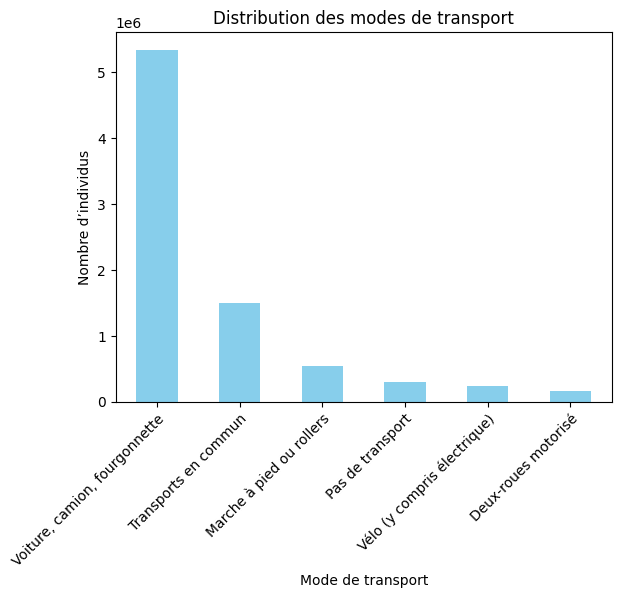

In [6]:
# Distribution des modes de transport utilisés pour aller travailler
transport_distribution = df_mobpro_brut['TRANS_LABEL'].value_counts()
print(transport_distribution)

# Visualisation
transport_distribution.plot(kind='bar', color='skyblue')
plt.xticks(rotation=45, ha='right', rotation_mode='anchor')
plt.title('Distribution des modes de transport')
plt.xlabel('Mode de transport')
plt.ylabel('Nombre d’individus')
plt.show()

TRANS_LABEL
Deux-roues motorisé              38.061997
Marche à pied ou rollers         38.992081
Pas de transport                 44.077751
Transports en commun             37.170818
Voiture, camion, fourgonnette    39.720284
Vélo (y compris électrique)      38.212106
Name: AGEREVQ, dtype: float64


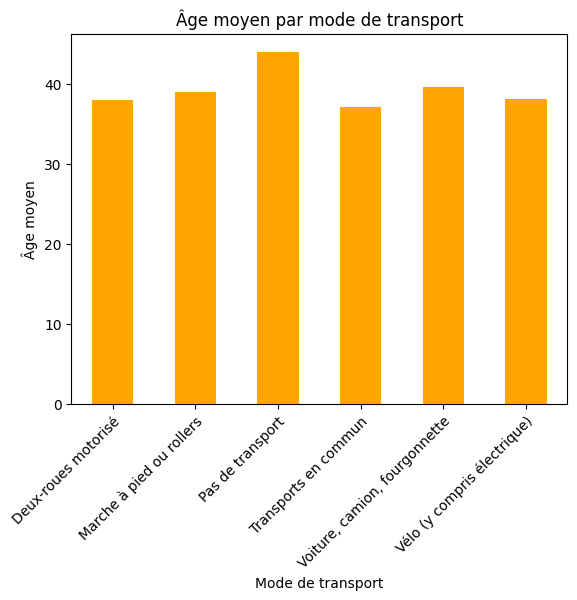

In [7]:
# Âge moyen par mode de transport
age_transport = df_mobpro_brut.groupby('TRANS_LABEL')['AGEREVQ'].mean()
print(age_transport)

# Visualisation
age_transport.plot(kind='bar', color='orange')
plt.xticks(rotation=45, ha='right', rotation_mode='anchor')
plt.title('Âge moyen par mode de transport')
plt.xlabel('Mode de transport')
plt.ylabel('Âge moyen')
plt.show()


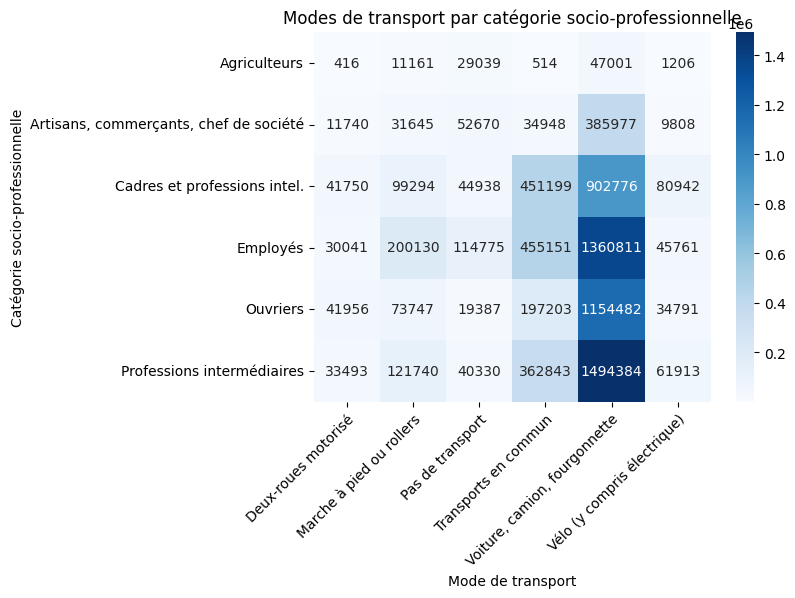

In [8]:
# Distribution des modes de transport par catégorie socio-professionnelle avec labels
cs1_transport = pd.crosstab(df_mobpro_brut['CS_LABEL'], df_mobpro_brut['TRANS_LABEL'])

# Heatmap
sns.heatmap(cs1_transport, annot=True, fmt='d', cmap='Blues')
plt.title('Modes de transport par catégorie socio-professionnelle')
plt.xlabel('Mode de transport')

# Inclinaison des labels avec alignement pour que l'extrémité pointe vers l'axe
plt.xticks(rotation=45, ha='right', rotation_mode='anchor')
plt.ylabel('Catégorie socio-professionnelle')
plt.show()


La fonction ci-dessous permet d'obtenir un premier tableau regroupant certaines informations par commune :
- Nombre de personnes du ménage (regroupé)
- Nombre de personnes scolarisées du ménage
- Nombre de personnes actives ayant un emploi du ménage
- Nombre d'élèves, étudiants ou stagiaires âgés de 14 ans ou plus du ménage
- Indicateur du lieu de travail
(1 Dans la commune de résidence actuelle
2 Dans une autre commune du département de résidence
3 Dans un autre département de la région de résidence
4 Hors de la région de résidence actuelle : en métropole
5 Hors de la région de résidence actuelle : dans un DOM
6 Hors de la région de résidence actuelle : dans une COM
7 A l'étranger)

In [9]:
# Conversion des colonnes en numérique
df_mobpro_brut['NPERR'] = pd.to_numeric(df_mobpro_brut['NPERR'], errors='coerce')
df_mobpro_brut['INPSM'] = pd.to_numeric(df_mobpro_brut['INPSM'], errors='coerce')
df_mobpro_brut['INPOM'] = pd.to_numeric(df_mobpro_brut['INPOM'], errors='coerce')
df_mobpro_brut['INEEM'] = pd.to_numeric(df_mobpro_brut['INEEM'], errors='coerce')

# Création des agrégations de base
mobpro_villes = df_mobpro_brut.groupby('COMMUNE').agg({
    'NPERR': 'sum',
    'INPSM': 'sum',
    'INPOM': 'sum',
    'INEEM': 'sum'})

# Créons d'abord un DataFrame temporaire pour chaque valeur d'ILT
for i in range(1, 8):
    # Grouper par COMMUNE et compter les occurrences où ILT == str(i)
    temp_count = df_mobpro_brut[df_mobpro_brut['ILT'] == i].groupby('COMMUNE').size()
    # Ajouter cette série au DataFrame principal
    mobpro_villes[f'ILT_{i}'] = temp_count

# Remplir les valeurs manquantes (NaN) par 0
mobpro_villes = mobpro_villes.fillna(0)

# Réinitialisation de l'index
mobpro_villes = mobpro_villes.reset_index()

In [10]:
mobpro_villes.head()

,COMMUNE,NPERR,INPSM,INPOM,INEEM,ILT_1,ILT_2,ILT_3,ILT_4,ILT_5,ILT_6,ILT_7
0,01001,275.0,65.0,194.0,13.0,11.0,58.0,20.0,1.0,0.0,0.0,0.0
1,01002,70.0,28.0,41.0,2.0,4.0,15.0,3.0,1.0,0.0,0.0,0.0
2,01004,6481.0,1787.0,3854.0,469.0,894.0,1105.0,422.0,33.0,0.0,0.0,5.0
3,01005,522.0,148.0,335.0,40.0,31.0,49.0,96.0,1.0,0.0,0.0,0.0
4,01006,35.0,4.0,31.0,0.0,1.0,7.0,5.0,0.0,0.0,0.0,0.0


On souhaite créer une matrice des flux pour avoir une vision générale des trajets domicile-travail quotidiens entre les villes. Pour chaque couple de ville, le nombre correspondant dans la matrice correspond au nombre de commute effectué de la ville 1 à la ville 2. 

On remarque que pour la variable "COMMUNE" (commune de résidence) on a uniquement 75056 pour Paris (idem pour Lyon et Marseille), tandis que pour la variable "DCLT" (commune de travail) on a un découpage en arrondissement avec les codes 75101,... pour Paris (idem pour Lyon et Marseille). Afin de pallier cette différence, on se cale sur l'échelle des arrondissements en remplaçant la valeur de "COMMUNE" par celle de "ARM" lorsque la ville en question est Paris, Marseille ou Lyon.

In [11]:
# Création d'une table croisée dynamique pour compter les déplacements
# Il faut que la matrice soit carrée pour qu'on ait bien tous les couples possibles de communes
flux_tot = pd.crosstab(df_mobpro_brut['COMMUNE'], df_mobpro_brut['DCLT'], dropna=False)
all_values = pd.Index(sorted(set(df_mobpro_brut['COMMUNE']).union(df_mobpro_brut['DCLT'])))
flux_tot_carre = flux_tot.reindex(index=all_values, columns=all_values, fill_value=0)
flux_tot=flux_tot_carre

# Conversion en DataFrame pour plus de clarté
flux_tot = pd.DataFrame(flux_tot)

# Pour voir les dimensions de la matrice
print("Dimensions de la matrice :", flux_tot.shape)

Dimensions de la matrice : (34946, 34946)


In [12]:
# Filtrer les données pour chaque groupe de transport
df_trans_45 = df_mobpro_brut[df_mobpro_brut['TRANS'].isin([4, 5])]
df_trans_6 = df_mobpro_brut[df_mobpro_brut['TRANS'] == 6]
df_trans_123 = df_mobpro_brut[df_mobpro_brut['TRANS'].isin([1, 2, 3])]

In [13]:
import pandas as pd

communes_unique = df_trans_45['COMMUNE'].nunique()
dclt_unique = df_trans_45['DCLT'].nunique()
flux_rouge = pd.crosstab(df_trans_45['COMMUNE'], df_trans_45['DCLT'], dropna=False)
all_values = pd.Index(sorted(set(df_trans_45['COMMUNE']).union(df_trans_45['DCLT'])))
flux_rouge_carre = flux_rouge.reindex(index=all_values, columns=all_values, fill_value=0)
print(f"Dimensions après réindexation : {flux_rouge_carre.shape}")
flux_rouge = flux_rouge_carre


Dimensions après réindexation : (34903, 34903)


In [14]:
# Créer la matrice des flux rouges

flux_rouge = pd.crosstab(df_trans_45['COMMUNE'], df_trans_45['DCLT'], dropna=False)
all_values = pd.Index(sorted(set(df_trans_45['COMMUNE']).union(df_trans_45['DCLT'])))
flux_rouge_carre = flux_rouge.reindex(index=all_values, columns=all_values, fill_value=0)
flux_rouge=flux_rouge_carre
print(flux_rouge.shape)

(34903, 34903)


In [15]:
# Créer la matrice des flux jaunes

flux_jaune = pd.crosstab(df_trans_6['COMMUNE'], df_trans_6['DCLT'], dropna=False)
all_values = pd.Index(sorted(set(df_trans_6['COMMUNE']).union(df_trans_6['DCLT'])))
flux_jaune_carre = flux_jaune.reindex(index=all_values, columns=all_values, fill_value=0)
flux_jaune=flux_jaune_carre
print(flux_jaune.shape)

(18985, 18985)


In [16]:
# Créer la matrice des flux verts

flux_vert = pd.crosstab(df_trans_123['COMMUNE'], df_trans_123['DCLT'], dropna=False)
all_values = pd.Index(sorted(set(df_trans_123['COMMUNE']).union(df_trans_123['DCLT'])))
flux_vert_carre = flux_vert.reindex(index=all_values, columns=all_values, fill_value=0)
flux_vert=flux_vert_carre
print(flux_vert.shape)

(30456, 30456)


In [17]:
# Convertir en DataFrame pour plus de clarté
flux_rouge = pd.DataFrame(flux_rouge)
flux_jaune = pd.DataFrame(flux_jaune)
flux_vert = pd.DataFrame(flux_vert)

# Afficher les dimensions des matrices
print("Dimensions de la matrice (TRANS = 4 ou 5) :", flux_rouge.shape)
print("Dimensions de la matrice (TRANS = 6) :", flux_jaune.shape)
print("Dimensions de la matrice (TRANS = 1, 2 ou 3) :", flux_vert.shape)


Dimensions de la matrice (TRANS = 4 ou 5) : (34903, 34903)
Dimensions de la matrice (TRANS = 6) : (18985, 18985)
Dimensions de la matrice (TRANS = 1, 2 ou 3) : (30456, 30456)


In [18]:
flux('78220', '75108', flux_jaune)

Nombre de personnes se déplaçant de 78220 vers 75108 : 2


In [19]:
flux_rouge

,01001,01002,01004,01005,01006,01007,01008,01009,01010,01011,...,98735,98736,98738,98753,98758,98807,98811,98815,98818,99999
01001,7,0,2,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
01002,0,3,2,0,0,2,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
01004,0,0,585,0,0,6,1,0,0,0,...,0,0,0,0,0,0,0,0,0,5
01005,0,0,0,19,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
01006,0,0,0,0,1,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
98807,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
98811,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
98815,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
98818,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [20]:
# Pour les départs : somme sur l'axe des colonnes (chaque ligne = ville de départ)
df_flux_jaune_depart = flux_jaune.sum(axis=1).reset_index()
df_flux_jaune_depart.columns = ['COMMUNE', 'flux_depart']

# Pour les arrivées : somme sur l'axe des lignes (chaque colonne = ville d'arrivée)
df_flux_jaune_destination = flux_jaune.sum(axis=0).reset_index()
df_flux_jaune_destination.columns = ['DCLT', 'flux_destination']

print("Départ :", df_flux_jaune_depart.head())
print("Destination :", df_flux_jaune_destination.head())

df_flux_vert_depart = flux_vert.sum(axis=1).reset_index()
df_flux_vert_depart.columns = ['COMMUNE', 'flux_depart']

# Pour les arrivées : somme sur l'axe des lignes (chaque colonne = ville d'arrivée)
df_flux_vert_destination = flux_vert.sum(axis=0).reset_index()
df_flux_vert_destination.columns = ['DCLT', 'flux_destination']

print("Départ :", df_flux_vert_depart.head())
print("Destination :", df_flux_vert_destination.head())

df_flux_rouge_depart = flux_rouge.sum(axis=1).reset_index()
df_flux_rouge_depart.columns = ['COMMUNE', 'flux_depart']

# Pour les arrivées : somme sur l'axe des lignes (chaque colonne = ville d'arrivée)
df_flux_rouge_destination = flux_rouge.sum(axis=0).reset_index()
df_flux_rouge_destination.columns = ['DCLT', 'flux_destination']

print("Départ :", df_flux_rouge_depart.head())
print("Destination :", df_flux_rouge_destination.head())


Départ :   COMMUNE  flux_depart
0   01001            1
1   01002            1
2   01004          342
3   01005            4
4   01007           21
Destination :     DCLT  flux_destination
0  01001                 0
1  01002                 0
2  01004               116
3  01005                 2
4  01007                 2
Départ :   COMMUNE  flux_depart
0   01001            4
1   01002            1
2   01004          297
3   01005           14
4   01007           10
Destination :     DCLT  flux_destination
0  01001                 4
1  01002                 1
2  01004               304
3  01005                12
4  01007                12
Départ :   COMMUNE  flux_depart
0   01001           85
1   01002           21
2   01004         1820
3   01005          159
4   01006           13
Destination :     DCLT  flux_destination
0  01001                11
1  01002                 4
2  01004              1644
3  01005                53
4  01006                 1


In [21]:
# Création d'un tableau superficies qui servira au calcul des émissions par villes
# En effet, la plupart des déplacements se font au sein d'une même ville En ayant la superficie des villes,
# on pourra calculer la distance moyenne entre deux points aléatoires tirés selon la probabilité uniforme 
# dans un cercle d'aire égale à la superficie de la ville (simplification arbitraire). 

# Conversion de geometry en un GeoDataFrame
contours_comm = gpd.GeoDataFrame(contours_comm)

# Reprojection des géométries en EPSG:2154 (Lambert 93, utilisé pour la France, mètres)
contours_comm = contours_comm.to_crs(epsg=2154)

# Calculer la surface des géométries en mètres carrés et conversion en km²
contours_comm['surface_m2'] = contours_comm.geometry.area
contours_comm['surface_km2'] = contours_comm['surface_m2'] / 1e6

# Création du tableau de superficies
superficies = contours_comm[['INSEE_COM', 'NOM', 'surface_km2']]

# Fusionner les communes des colonnes 'COMMUNE' et 'DCLT' dans df_mobpro_brut
communes_residence_travail = pd.concat([df_mobpro_brut['COMMUNE'], df_mobpro_brut['DCLT']]).drop_duplicates()

# Convertir la Série en DataFrame et renommer la colonne
communes_residence_travail = communes_residence_travail.to_frame(name='COMMUNE')

# Effectuer une jointure avec superficies sur les communes fusionnées
superficies = pd.merge(communes_residence_travail, superficies, left_on='COMMUNE', right_on='INSEE_COM', how='left')

print(f"Nombre de lignes dans le tableau final : {superficies.shape[0]}")
print(superficies)
# On a bien 34946 lignes, soit le nombre de communes en France : rien n'a été oublié

Nombre de lignes dans le tableau final : 34946
      COMMUNE INSEE_COM                      NOM  surface_km2
0       01001     01001  L'Abergement-Clémenciat    15.619934
1       01002     01002    L'Abergement-de-Varey     9.175479
2       01004     01004        Ambérieu-en-Bugey    24.508833
3       01005     01005      Ambérieux-en-Dombes    16.014205
4       01006     01006                  Ambléon     6.030856
...       ...       ...                      ...          ...
34941   98805       NaN                      NaN          NaN
34942   97601     97601                    Acoua    32.341000
34943   97614     97614                 Ouangani    47.892143
34944   97501       NaN                      NaN          NaN
34945   97606     97606                Chirongui    67.177153

[34946 rows x 4 columns]


In [22]:
'''J'ai eu un crash de kernel sur ce programme je ne comprends pas  pk'''

# # Calcul des sommes des lignes et des colonnes
#somme_lignes = flux_rouge.sum(axis=1).values  # on prend les valeurs sous forme de tableau numpy
#somme_colonnes = flux_rouge.sum(axis=0).values  # idem pour les colonnes

# # Créer la matrice nombre_total_de_commute en utilisant la diffusion de numpy (broadcasting)
# # Remplir une matrice de la forme de flux_rouge avec la somme des lignes et des colonnes
# nombre_total_de_commute = (somme_lignes[:, None] + somme_colonnes[None, :]) - flux_rouge.values

# # Transformer en DataFrame pour une présentation claire
# nombre_total_de_commute_df = pd.DataFrame(nombre_total_de_commute, columns=flux_rouge.columns, index=flux_rouge.index)

# # Afficher la matrice résultante
# print(nombre_total_de_commute_df)


"J'ai eu un crash de kernel sur ce programme je ne comprends pas  pk"

In [23]:
df_flux_jaune_depart_m = pd.merge(
        contours_comm[['INSEE_COM', 'NOM', 'POPULATION', 'INSEE_DEP', 'SIREN_EPCI', 'geometry']],
        df_flux_jaune_depart,
        left_on='INSEE_COM',
        right_on="COMMUNE",
        how='left')
df_flux_jaune_depart_m["flux_depart"] = df_flux_jaune_depart_m["flux_depart"].fillna(0).astype(int)

df_flux_vert_depart_m = pd.merge(
        contours_comm[['INSEE_COM', 'NOM', 'POPULATION', 'INSEE_DEP', 'SIREN_EPCI', 'geometry']],
        df_flux_vert_depart,
        left_on='INSEE_COM',
        right_on="COMMUNE",
        how='left')
df_flux_vert_depart_m["flux_depart"] = df_flux_vert_depart_m["flux_depart"].fillna(0).astype(int)

df_flux_rouge_depart_m = pd.merge(
        contours_comm[['INSEE_COM', 'NOM', 'POPULATION', 'INSEE_DEP', 'SIREN_EPCI', 'geometry']],
        df_flux_rouge_depart,
        left_on='INSEE_COM',
        right_on="COMMUNE",
        how='left')
df_flux_rouge_depart_m["flux_depart"] = df_flux_rouge_depart_m["flux_depart"].fillna(0).astype(int)


df_flux_jaune_destination_m = pd.merge(
        contours_comm[['INSEE_COM', 'NOM', 'POPULATION', 'INSEE_DEP', 'SIREN_EPCI', 'geometry']],
        df_flux_jaune_destination,
        left_on='INSEE_COM',
        right_on="DCLT",
        how='left')
df_flux_jaune_destination_m["flux_destination"] = df_flux_jaune_destination_m["flux_destination"].fillna(0).astype(int)

df_flux_vert_destination_m = pd.merge(
        contours_comm[['INSEE_COM', 'NOM', 'POPULATION', 'INSEE_DEP', 'SIREN_EPCI', 'geometry']],
        df_flux_vert_destination,
        left_on='INSEE_COM',
        right_on="DCLT",
        how='left')
df_flux_vert_destination_m["flux_destination"] = df_flux_vert_destination_m["flux_destination"].fillna(0).astype(int)

df_flux_rouge_destination_m = pd.merge(
        contours_comm[['INSEE_COM', 'NOM', 'POPULATION', 'INSEE_DEP', 'SIREN_EPCI', 'geometry']],
        df_flux_rouge_destination,
        left_on='INSEE_COM',
        right_on="DCLT",
        how='left')
df_flux_rouge_destination_m["flux_destination"] = df_flux_rouge_destination_m["flux_destination"].fillna(0).astype(int)

In [24]:
""" OBTENTION DE final_df RECENSANT POUR CHAQUE VILLE TOUS LES TYPES DE FLUX ET INFOS SOCIO"""
""" OBTENTION DE df_epci_contours INDIQUANT POUR CHAQUE EPCI QUELQUES CARACTERISTIQUES ET SES CONTOURS"""

# Merge des données socio et contours communes
df_socio = pd.merge(
    contours_comm,
    df_dossier_complet_brut[['CODGEO', 'P21_SAL15P', 'C21_MEN', 'P21_ACTOCC15P_TP']],
    left_on='INSEE_COM',
    right_on='CODGEO',
    how='left')
    
# Fusionner tous les flux dans un unique DataFrame
final_df = df_socio[['INSEE_COM', 'NOM', 'POPULATION', 'INSEE_DEP', 'SIREN_EPCI', 'geometry', 'P21_SAL15P', 'C21_MEN', 'P21_ACTOCC15P_TP']].copy()

# Ajouter les colonnes de flux en les fusionnant avec le DataFrame principal
for color in ['jaune', 'vert', 'rouge']:
    df_depart = globals()[f'df_flux_{color}_depart']
    df_destination = globals()[f'df_flux_{color}_destination']
    
    df_depart_m = pd.merge(final_df, df_depart, left_on='INSEE_COM', right_on='COMMUNE', how='left')
    df_destination_m = pd.merge(final_df, df_destination, left_on='INSEE_COM', right_on='DCLT', how='left')
    
    final_df[f'flux_depart_{color}'] = df_depart_m['flux_depart'].fillna(0).astype(int)
    final_df[f'flux_destination_{color}'] = df_destination_m['flux_destination'].fillna(0).astype(int)

# Renommer les colonnes
final_df = final_df.rename(columns={
    'P21_SAL15P': 'Nb actifs occupés en 2021',
    'C21_MEN': 'Nb ménages en 2021',
    'P21_ACTOCC15P_TP': 'Nb actifs à temps partiel'})

# Conversion en GeoDataFrame si nécessaire
if not isinstance(final_df, gpd.GeoDataFrame):
    final_df = gpd.GeoDataFrame(final_df, geometry='geometry')

# Partie données
df_epci_data = final_df.groupby('SIREN_EPCI').agg({
    'NOM': list,
    'INSEE_COM': list,
    'INSEE_DEP': list,
    'POPULATION': 'sum',
    'Nb actifs à temps partiel': 'sum',
    'Nb ménages en 2021':'sum',
    'Nb actifs occupés en 2021':'sum'
}).reset_index()

# Partie géométrie
df_epci_geo = final_df.dissolve(by='SIREN_EPCI')

# Merge des deux
df_epci_contours = df_epci_data.merge(df_epci_geo[['geometry']], left_on='SIREN_EPCI', right_index=True)


In [25]:
df_epci_contours.head()

,SIREN_EPCI,NOM,INSEE_COM,INSEE_DEP,POPULATION,Nb actifs à temps partiel,Nb ménages en 2021,Nb actifs occupés en 2021,geometry
0,200000172,"[Marignier, Contamine-sur-Arve, Glières-Val-de...","[74164, 74087, 74212, 74312, 74049, 74042, 74024]","[74, 74, 74, 74, 74, 74, 74]",27218.0,2218.427898,11802.018216,12031.433753,"POLYGON ((967052.3 6556343.9, 967045.7 6556329..."
1,200000438,"[Crossac, Pontchâteau, Sainte-Anne-sur-Brivet,...","[44050, 44129, 44152, 44098, 44068, 44196, 441...","[44, 44, 44, 44, 44, 44, 44, 44, 44]",35917.0,2756.235128,15784.280047,14384.550345,"POLYGON ((325044.8 6719783.3, 325064.2 6719753..."
2,200000545,"[Crancey, Saint-Hilaire-sous-Romilly, Romilly-...","[10114, 10341, 10323, 10164, 10220, 10280]","[10, 10, 10, 10, 10, 10]",18739.0,874.965660,8665.218943,5446.249610,"POLYGON ((751763.4 6819199.7, 751729 6819176.1..."
3,200000628,"[Lapalud, Mondragon, Mornas, Lamotte-du-Rhône,...","[84064, 84078, 84083, 84063, 84019]","[84, 84, 84, 84, 84]",24224.0,1442.982297,10773.779439,7526.326339,"POLYGON ((841785.2 6347339.5, 841574.2 6347339..."
4,200000800,"[Chaumont-sur-Tharonne, Chaon, Vouzon, Nouan-l...","[41046, 41036, 41296, 41161, 41106, 41251]","[41, 41, 41, 41, 41, 41]",10437.0,550.174086,4746.154398,3763.453777,"POLYGON ((631422.5 6721239, 631378 6721141.6, ..."


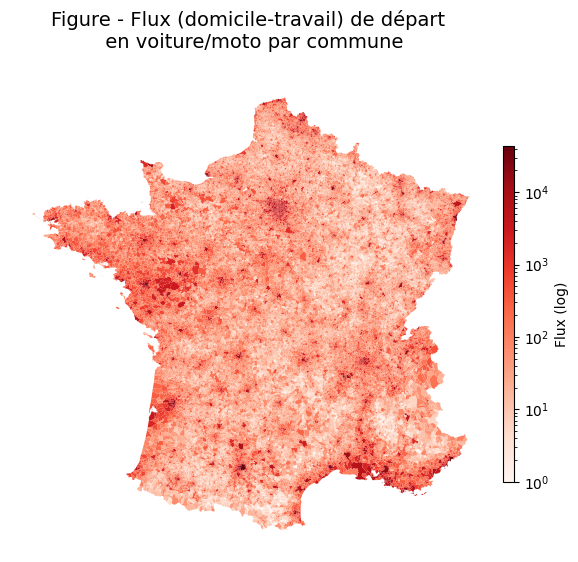

In [26]:
plot_flux_gradient(df_flux_rouge_depart_m, "rouge", "Figure - Flux (domicile-travail) de départ \n en voiture/moto par commune","flux_depart")

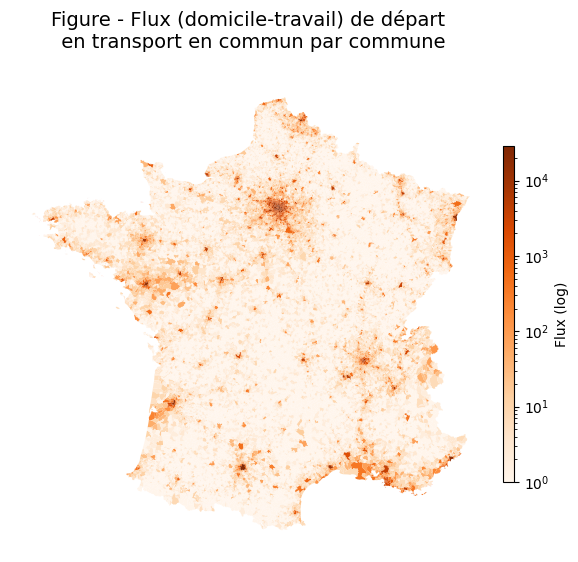

In [27]:
plot_flux_gradient(df_flux_jaune_depart_m, "jaune", "Figure - Flux (domicile-travail) de départ \n en transport en commun par commune","flux_depart")

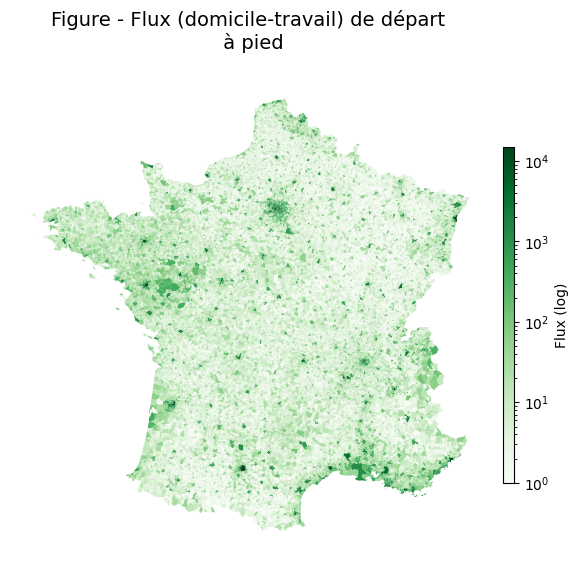

In [28]:
plot_flux_gradient(df_flux_vert_depart_m, "vert", "Figure - Flux (domicile-travail) de départ \n à pied","flux_depart")

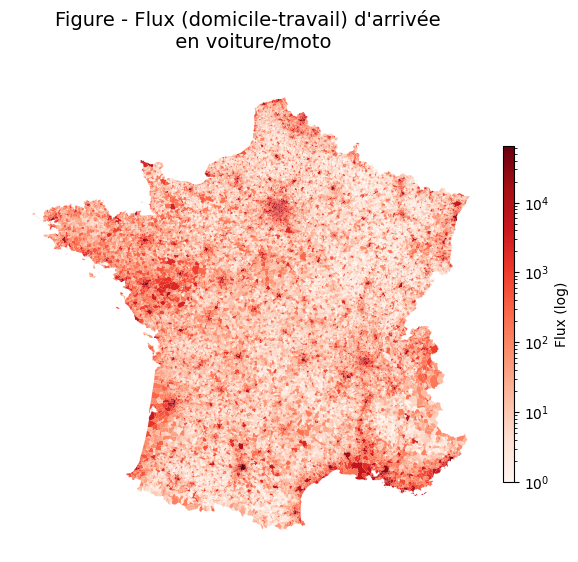

In [29]:
plot_flux_gradient(df_flux_rouge_destination_m, "rouge", "Figure - Flux (domicile-travail) d'arrivée \n en voiture/moto","flux_destination")

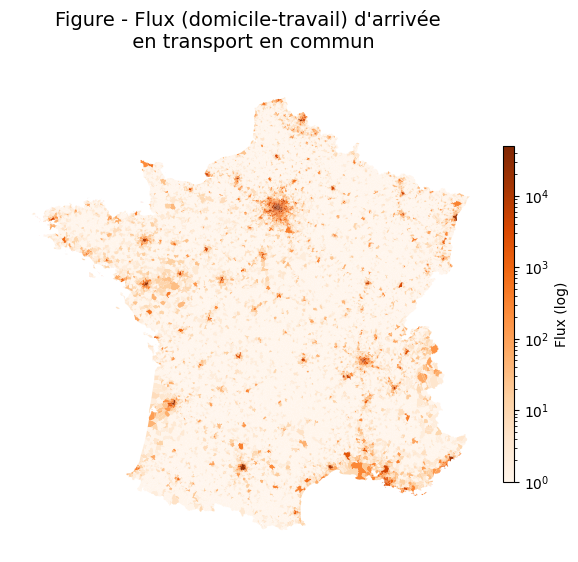

In [30]:
plot_flux_gradient(df_flux_jaune_destination_m, "jaune", "Figure - Flux (domicile-travail) d'arrivée \n en transport en commun","flux_destination")

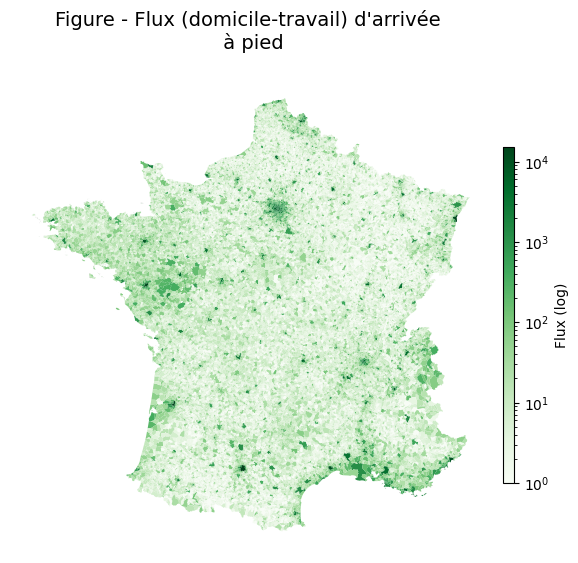

In [31]:
plot_flux_gradient(df_flux_vert_destination_m, "vert", "Figure - Flux (domicile-travail) d'arrivée \n à pied","flux_destination")

/home/onyxia/work/statapp/script.py:257: UserWarning: Geometry is in a geographic CRS. Results from 'centroid' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.

  centroid = ville_cible.centroid.iloc[0]


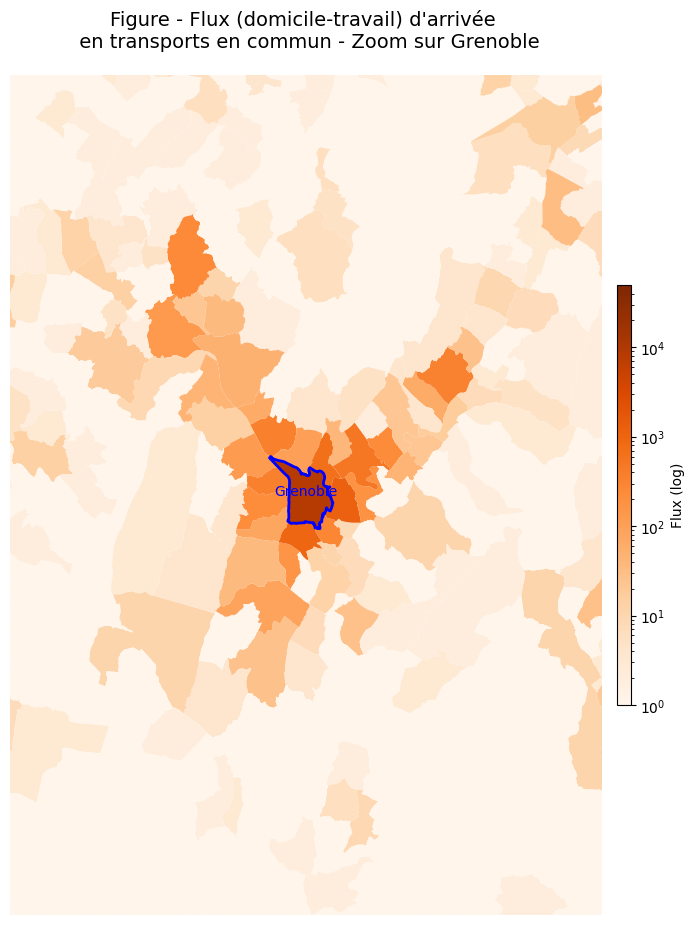

In [32]:
plot_flux_gradient_zoom(df_flux_jaune_destination_m, "jaune", "Figure - Flux (domicile-travail) d'arrivée \n en transports en commun","flux_destination", "grenoble")

In [33]:
def est_mono_departement(liste_departements):
    '''
    On vérifie si les EPCI regroupent forcément des villes qui appartiennent au même département (réponse = non pas systématiquement)
    '''
    return len(set(liste_departements)) == 1
    
    
# Appliquer la fonction à chaque ligne et créer une nouvelle colonne
df_epci_contours['MONO_DEP'] = df_epci_contours['INSEE_DEP'].apply(est_mono_departement)

In [34]:
"""OBTENTION DE gdf_epci_metropole IGNORANT LES EPCI HORS FRANCE METROPOLITAINE"""

def est_metropole(liste_departements):
    """
    On ne souhaite afficher que la France Métropolitaine et exclure les DOM-TOM et la Corse.
    """
    # Filtrage : ignorer les départements dont le code dépasse 3 caractères
    liste_departements = [dep for dep in liste_departements if len(str(dep)) <= 3]

    for dep in liste_departements:
        # On vérifie si le code contient des lettres, comme '2A' ou '2B'
        if any(c.isalpha() for c in dep):
            return False  # Exclure la Corse ou d'autres DOM-TOM avec des lettres

        # Comparer avec 970 pour la métropole
        if int(dep) >= 970:
            return False  # Exclure les départements DOM-TOM
    
    return True  # Si toutes les conditions sont remplies, c'est en métropole
    
gdf_epci_metropole = df_epci_contours[df_epci_contours['INSEE_DEP'].apply(est_metropole)]


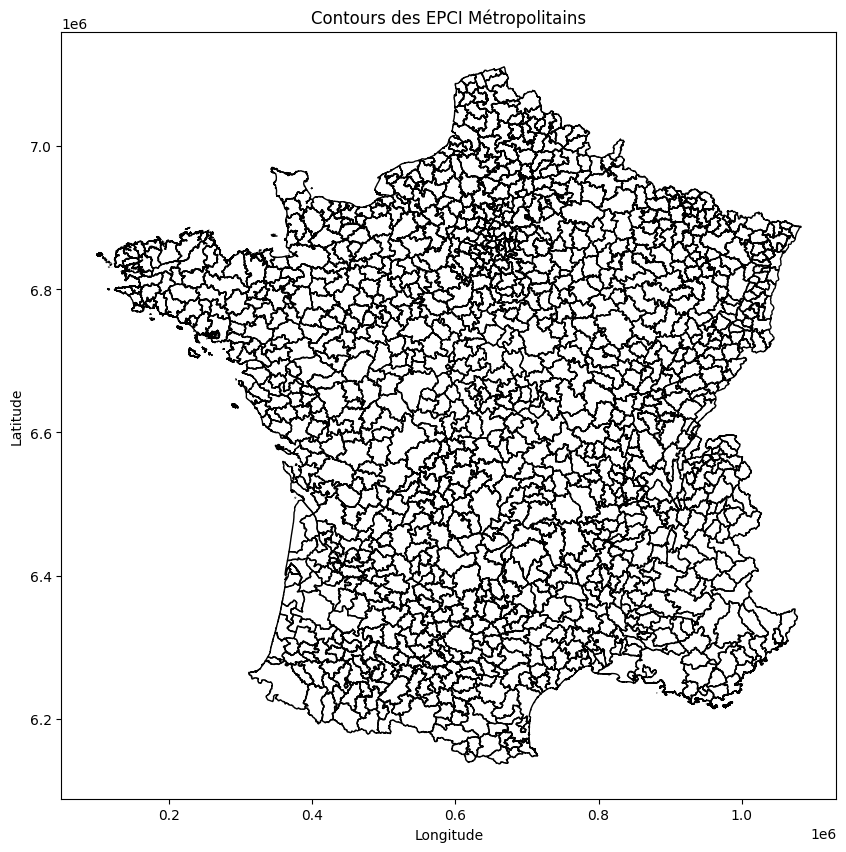

In [35]:
""" AFFICHAGE CARTE EPCI"""

gdf_epci_metropole = gpd.GeoDataFrame(gdf_epci_metropole, geometry='geometry')

# Tracer les géométries
fig, ax = plt.subplots(figsize=(10, 10))  # Taille de la figure
gdf_epci_metropole.plot(ax=ax, edgecolor='black', facecolor='none', linewidth=1)
plt.title("Contours des EPCI Métropolitains")
plt.xlabel("Longitude")
plt.ylabel("Latitude")
plt.show()

In [36]:
""" OBTENTION DE df_epci_flux QUI RECENSE LES NOMBRES DE FLUX PAR EPCI"""

# Merge pour récupérer EPCI de départ
df_mobpro_brut = df_mobpro_brut.merge(
    contours_comm[['INSEE_COM', 'SIREN_EPCI']],
    left_on='COMMUNE',
    right_on='INSEE_COM',
    how='left'
).rename(columns={'SIREN_EPCI': 'EPCI_DEP'}).drop('INSEE_COM', axis=1)

# Merge pour récupérer EPCI d'arrivée
df_mobpro_brut = df_mobpro_brut.merge(
    contours_comm[['INSEE_COM', 'SIREN_EPCI']],
    left_on='DCLT',
    right_on='INSEE_COM',
    how='left'
).rename(columns={'SIREN_EPCI': 'EPCI_ARR'}).drop('INSEE_COM', axis=1)

df_mobpro_brut['is_intra'] = df_mobpro_brut['EPCI_DEP'] == df_mobpro_brut['EPCI_ARR']

# Calcul des flux intra
flux_intra = df_mobpro_brut[df_mobpro_brut['is_intra']].groupby('EPCI_DEP').size().reset_index(name='flux_intra_epci')

# Calcul des flux sortants
flux_sortant = df_mobpro_brut[~df_mobpro_brut['is_intra']].groupby('EPCI_DEP').size().reset_index(name='flux_sortant')

# Calcul des flux entrants
flux_entrant = df_mobpro_brut[~df_mobpro_brut['is_intra']].groupby('EPCI_ARR').size().reset_index(name='flux_entrant')

# Calcul des flux par type de transport (TRANS = 6 : TC, TRANS = 1,2,3 : Zero, TRANS = 4,5 : VC2RM)
flux_sortant_TC = df_mobpro_brut[(df_mobpro_brut['TRANS'] == 6) & (~df_mobpro_brut['is_intra'])].groupby('EPCI_DEP').size().reset_index(name='flux_sortant_TC')
flux_entrant_TC = df_mobpro_brut[(df_mobpro_brut['TRANS'] == 6) & (~df_mobpro_brut['is_intra'])].groupby('EPCI_ARR').size().reset_index(name='flux_entrant_TC')
flux_sortant_VC2RM = df_mobpro_brut[(df_mobpro_brut['TRANS'].isin([4, 5])) & (~df_mobpro_brut['is_intra'])].groupby('EPCI_DEP').size().reset_index(name='flux_sortant_VC2RM')
flux_entrant_VC2RM = df_mobpro_brut[(df_mobpro_brut['TRANS'].isin([4, 5])) & (~df_mobpro_brut['is_intra'])].groupby('EPCI_ARR').size().reset_index(name='flux_entrant_VC2RM')
flux_sortant_Zero = df_mobpro_brut[(df_mobpro_brut['TRANS'].isin([1, 2, 3])) & (~df_mobpro_brut['is_intra'])].groupby('EPCI_DEP').size().reset_index(name='flux_sortant_Zero')
flux_entrant_Zero = df_mobpro_brut[(df_mobpro_brut['TRANS'].isin([1, 2, 3])) & (~df_mobpro_brut['is_intra'])].groupby('EPCI_ARR').size().reset_index(name='flux_entrant_Zero')

# Création du DataFrame final avec SIREN_EPCI comme clé unique
# Commencer par créer un DataFrame avec tous les EPCI uniques
all_epci = pd.concat([
    flux_intra[['EPCI_DEP']],
    flux_sortant[['EPCI_DEP']],
    flux_entrant[['EPCI_ARR']].rename(columns={'EPCI_ARR': 'EPCI_DEP'}),
    flux_sortant_TC[['EPCI_DEP']],
    flux_entrant_TC[['EPCI_ARR']].rename(columns={'EPCI_ARR': 'EPCI_DEP'}),
    flux_sortant_VC2RM[['EPCI_DEP']],
    flux_entrant_VC2RM[['EPCI_ARR']].rename(columns={'EPCI_ARR': 'EPCI_DEP'}),
    flux_sortant_Zero[['EPCI_DEP']],
    flux_entrant_Zero[['EPCI_ARR']].rename(columns={'EPCI_ARR': 'EPCI_DEP'})
]).drop_duplicates().rename(columns={'EPCI_DEP': 'SIREN_EPCI'})

# Fusion des flux dans un seul DataFrame
df_epci_flux = all_epci.copy()

# Fusionner tous les flux en utilisant des suffixes explicites et en maintenant SIREN_EPCI comme clé
df_epci_flux = pd.merge(df_epci_flux, flux_intra.rename(columns={'EPCI_DEP': 'SIREN_EPCI'}), 
                        on='SIREN_EPCI', how='left')

df_epci_flux = pd.merge(df_epci_flux, flux_sortant.rename(columns={'EPCI_DEP': 'SIREN_EPCI'}), 
                        on='SIREN_EPCI', how='left')

df_epci_flux = pd.merge(df_epci_flux, flux_entrant.rename(columns={'EPCI_ARR': 'SIREN_EPCI'}), 
                        on='SIREN_EPCI', how='left')

df_epci_flux = pd.merge(df_epci_flux, flux_sortant_TC.rename(columns={'EPCI_DEP': 'SIREN_EPCI'}), 
                        on='SIREN_EPCI', how='left')

df_epci_flux = pd.merge(df_epci_flux, flux_entrant_TC.rename(columns={'EPCI_ARR': 'SIREN_EPCI'}), 
                        on='SIREN_EPCI', how='left')

df_epci_flux = pd.merge(df_epci_flux, flux_sortant_VC2RM.rename(columns={'EPCI_DEP': 'SIREN_EPCI'}), 
                        on='SIREN_EPCI', how='left')

df_epci_flux = pd.merge(df_epci_flux, flux_entrant_VC2RM.rename(columns={'EPCI_ARR': 'SIREN_EPCI'}), 
                        on='SIREN_EPCI', how='left')

df_epci_flux = pd.merge(df_epci_flux, flux_sortant_Zero.rename(columns={'EPCI_DEP': 'SIREN_EPCI'}), 
                        on='SIREN_EPCI', how='left')

df_epci_flux = pd.merge(df_epci_flux, flux_entrant_Zero.rename(columns={'EPCI_ARR': 'SIREN_EPCI'}), 
                        on='SIREN_EPCI', how='left')

# Remplacer les NA par des 0
df_epci_flux = df_epci_flux.fillna(0)

# Convertir en int
for col in ['flux_intra_epci', 'flux_sortant', 'flux_entrant', 'flux_sortant_TC', 'flux_entrant_TC', 
            'flux_sortant_VC2RM', 'flux_entrant_VC2RM', 'flux_sortant_Zero', 'flux_entrant_Zero']:
    df_epci_flux[col] = df_epci_flux[col].astype(int)

# Résultat final
df_epci_flux.head()

,SIREN_EPCI,flux_intra_epci,flux_sortant,flux_entrant,flux_sortant_TC,flux_entrant_TC,flux_sortant_VC2RM,flux_entrant_VC2RM,flux_sortant_Zero,flux_entrant_Zero
0,200000172,1431,2391,2239,71,71,2271,2132,49,36
1,200000438,1233,2451,880,105,17,2330,854,16,9
2,200000545,1070,1001,770,199,35,784,723,18,12
3,200000628,1137,1386,1027,47,29,1326,993,13,5
4,200000800,432,408,410,33,41,367,364,8,5


In [37]:
gdf_epci = gdf_epci_metropole.merge(df_epci_flux[['SIREN_EPCI', 'flux_intra_epci', 'flux_sortant', 'flux_entrant','flux_sortant_TC','flux_entrant_TC','flux_sortant_VC2RM','flux_entrant_VC2RM','flux_sortant_Zero','flux_entrant_Zero']], on='SIREN_EPCI', how='left')

In [38]:
gdf_epci.sample()

,SIREN_EPCI,NOM,INSEE_COM,INSEE_DEP,POPULATION,Nb actifs à temps partiel,Nb ménages en 2021,Nb actifs occupés en 2021,geometry,MONO_DEP,flux_intra_epci,flux_sortant,flux_entrant,flux_sortant_TC,flux_entrant_TC,flux_sortant_VC2RM,flux_entrant_VC2RM,flux_sortant_Zero,flux_entrant_Zero
630,200071652,"[Le Champ-de-la-Pierre, La Lande-de-Goult, Sai...","[61085, 61216, 61419, 61243, 61104, 61424, 614...","[61, 61, 61, 61, 61, 61, 61, 61, 61, 61, 61, 6...",4878.0,313.683018,2163.478974,1637.66397,"POLYGON ((452223.3 6825655.2, 452183.9 6825650...",True,133,287,122,8,1,275,120,4,1


In [39]:
# Calcul du ratio (éviter la division par zéro)
gdf_epci['ratio'] = gdf_epci['flux_sortant'] / gdf_epci['flux_entrant'].replace(0, 1)

# Nettoyage de la colonne INSEE_DEP en supprimant les doublons dans les listes
gdf_epci['INSEE_DEP'] = gdf_epci['INSEE_DEP'].apply(lambda x: list(set(x)) if isinstance(x, list) else x)

In [40]:
from sklearn.cluster import KMeans
from sklearn.preprocessing import StandardScaler

# --- Exemple de données : chaque ligne est une ville, chaque colonne une variable ---
data = gdf_epci

# --- Sélection des variables à utiliser ---
selected_vars = ['ratio', 'Nb actifs occupés en 2021', 'flux_entrant_TC']  # On choisit les variables pertinentes
X = data[selected_vars].copy()  # On extrait les données

# --- Pondération des variables (facultatif) ---
weights = np.array([0.4, 0.3, 0.3])  # Importance de chaque variable
X_weighted = X * weights  # Multiplication élément par élément

# --- Normalisation des données ---
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X_weighted)  # Mise à l'échelle pour équilibrer les unités

# --- Application du K-Means ---
k = 10  # Nombre de clusters (à adapter selon l'analyse)
kmeans = KMeans(n_clusters=k, random_state=42, n_init=10)
data['cluster'] = kmeans.fit_predict(X_scaled)  # Ajout des clusters au DataFrame

# --- Affichage des résultats ---
print(data[['SIREN_EPCI', 'cluster']])

     SIREN_EPCI  cluster
0     200000172        2
1     200000438        0
2     200000545        7
3     200000628        7
4     200000800        2
...         ...      ...
1220  249500430        7
1221  249500455        0
1222  249500489        7
1223  249500513        7
1224         NR        7

[1225 rows x 2 columns]


/tmp/ipykernel_8977/3422308382.py:5: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed in 3.11. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap()`` or ``pyplot.get_cmap()`` instead.
  colors = plt.cm.get_cmap('tab20', num_clusters)  # 'tab20', 'viridis', etc.


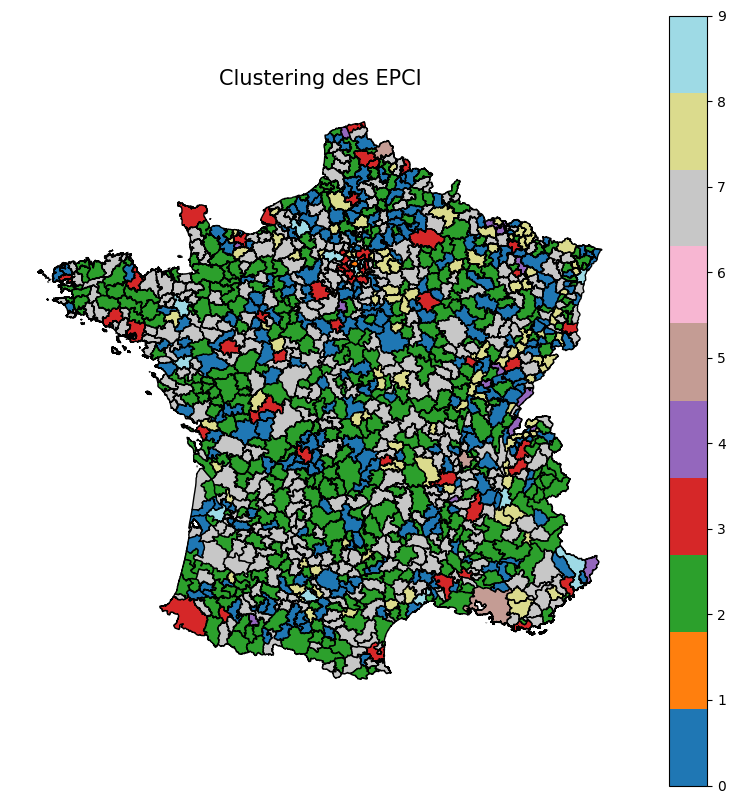

In [41]:
import matplotlib.colors as mcolors

# Définir une palette de couleurs adaptée au nombre de clusters
num_clusters = data['cluster'].nunique()
colors = plt.cm.get_cmap('tab20', num_clusters)  # 'tab20', 'viridis', etc.

# Associer une couleur à chaque cluster
data['color'] = data['cluster'].apply(lambda x: colors(x))

# Tracer la carte
fig, ax = plt.subplots(figsize=(10, 10))
data.plot(column='cluster', cmap=colors, legend=True, edgecolor="black", ax=ax)

# Personnalisation
ax.set_title("Clustering des EPCI", fontsize=15)
ax.axis("off")  # Supprimer les axes

# Afficher la carte
plt.show()


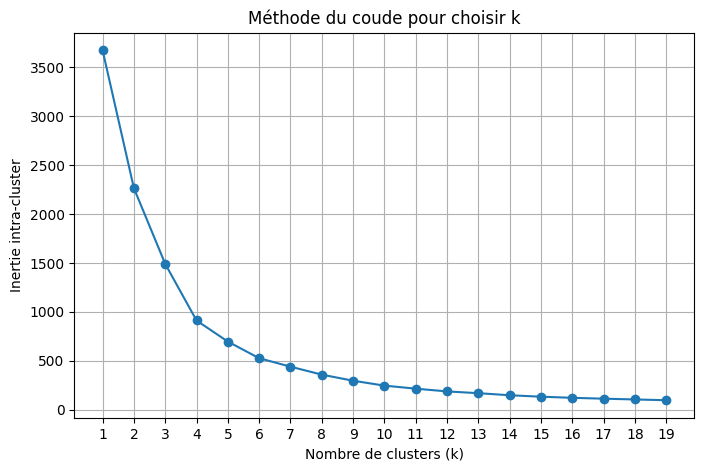

In [42]:
selected_vars = ['ratio', 'Nb actifs occupés en 2021', 'flux_entrant_TC']  
X = data[selected_vars].copy()

# --- Pondération des variables ---
weights = np.array([0.4, 0.3, 0.3])  # Importance de chaque variable
X_weighted = X * weights  # Multiplication élément par élément

# --- Normalisation des données ---
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

# --- Test de plusieurs valeurs de k ---
inerties = []
k_values = range(1, 20)  # Tester de 1 à 20 clusters

for k in k_values:
    kmeans = KMeans(n_clusters=k, random_state=42, n_init=10)
    kmeans.fit(X_scaled)
    inerties.append(kmeans.inertia_)  # Stocker l'inertie

# --- Tracer la courbe du coude ---
plt.figure(figsize=(8, 5))
plt.plot(k_values, inerties, marker='o', linestyle='-')
plt.xlabel("Nombre de clusters (k)")
plt.ylabel("Inertie intra-cluster")
plt.title("Méthode du coude pour choisir k")
plt.xticks(k_values)
plt.grid()
plt.show()

/tmp/ipykernel_8977/1451864155.py:23: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed in 3.11. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap()`` or ``pyplot.get_cmap()`` instead.
  colors = plt.cm.get_cmap('tab20', num_clusters)  # 'tab20', 'viridis', etc.


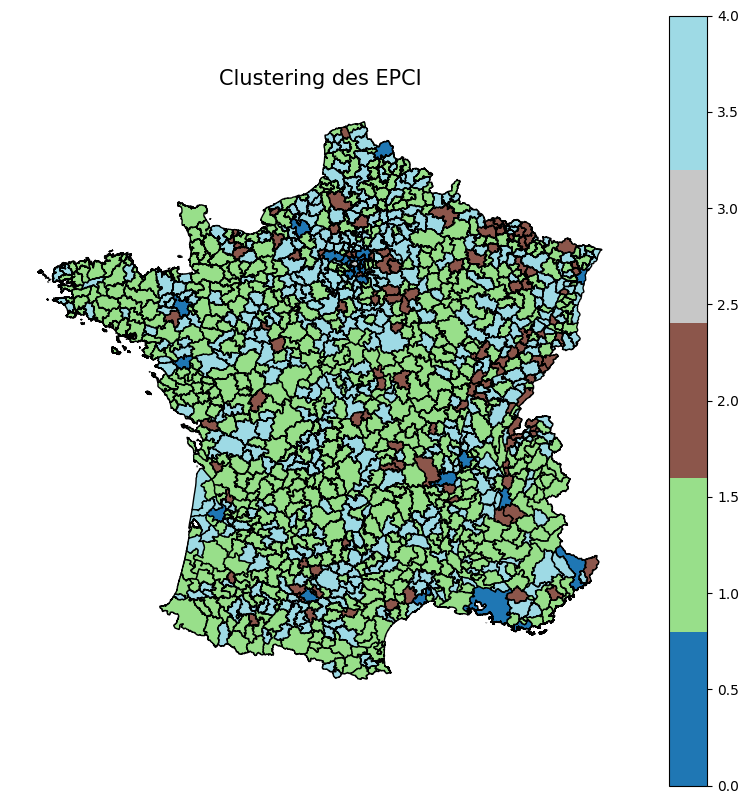

In [43]:
# --- Exemple de données : chaque ligne est une ville, chaque colonne une variable ---
data = gdf_epci

# --- Sélection des variables à utiliser ---
selected_vars = ['ratio', 'Nb actifs occupés en 2021', 'flux_entrant_TC']  # On choisit les variables pertinentes
X = data[selected_vars].copy()  # On extrait les données

# --- Pondération des variables (facultatif) ---
weights = np.array([0.4, 0.3, 0.3])  # Importance de chaque variable
X_weighted = X * weights  # Multiplication élément par élément

# --- Normalisation des données ---
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X_weighted)  # Mise à l'échelle pour équilibrer les unités

# --- Application du K-Means ---
k = 5  # Nombre de clusters (à adapter selon l'analyse)
kmeans = KMeans(n_clusters=k, random_state=42, n_init=10)
data['cluster'] = kmeans.fit_predict(X_scaled)  # Ajout des clusters au DataFrame

# Définir une palette de couleurs adaptée au nombre de clusters
num_clusters = data['cluster'].nunique()
colors = plt.cm.get_cmap('tab20', num_clusters)  # 'tab20', 'viridis', etc.

# Associer une couleur à chaque cluster
data['color'] = data['cluster'].apply(lambda x: colors(x))

# Tracer la carte
fig, ax = plt.subplots(figsize=(10, 10))
data.plot(column='cluster', cmap=colors, legend=True, edgecolor="black", ax=ax)

# Personnalisation
ax.set_title("Clustering des EPCI", fontsize=15)
ax.axis("off")  # Supprimer les axes

# Afficher la carte
plt.show()


In [44]:
# Moyennes par cluster
cluster_summary_mean = data.groupby('cluster')[selected_vars].mean().reset_index()

print(cluster_summary_mean)


   cluster     ratio  Nb actifs occupés en 2021  flux_entrant_TC
0        0  1.030982              218356.643509     11554.466667
1        1  1.051189               16454.010560       131.779687
2        2  4.160834               10782.165484        63.017699
3        3  0.325851              883898.676070    299998.000000
4        4  2.245383                9697.993444        34.424036


In [45]:
recap = data.groupby('cluster').agg({
    'ratio': ['mean', 'std'],
    'Nb actifs occupés en 2021': ['mean', 'std'],
    'flux_entrant_TC': ['mean', 'std']
}).reset_index()

# Nommage des colonnes
recap.columns = ['cluster',
                 'ratio_mean', 'ratio_std',
                 'actifs_mean', 'actifs_std',
                 'flux_TC_mean', 'flux_TC_std']

In [46]:
recap

,cluster,ratio_mean,ratio_std,actifs_mean,actifs_std,flux_TC_mean,flux_TC_std
0,0,1.030982,0.595069,218356.643509,124413.384071,11554.466667,16914.304937
1,1,1.051189,0.342278,16454.010560,19967.026597,131.779687,564.186866
2,2,4.160834,1.024330,10782.165484,15140.898529,63.017699,291.405706
3,3,0.325851,NaN,883898.676070,NaN,299998.000000,NaN
4,4,2.245383,0.427279,9697.993444,9456.037093,34.424036,106.135331


In [47]:
gdf_epci[gdf_epci["cluster"]==3]

,SIREN_EPCI,NOM,INSEE_COM,INSEE_DEP,POPULATION,Nb actifs à temps partiel,Nb ménages en 2021,Nb actifs occupés en 2021,geometry,MONO_DEP,...,flux_entrant,flux_sortant_TC,flux_entrant_TC,flux_sortant_VC2RM,flux_entrant_VC2RM,flux_sortant_Zero,flux_entrant_Zero,ratio,cluster,color
256,200054781,"[Paris 2e Arrondissement, Paris 9e Arrondissem...","[75102, 75109, 75111, 75117, 75103, 75101, 751...",[75],2145906.0,161930.110098,1.128286e+06,883898.67607,"POLYGON ((651812.5 6857505.6, 651799.3 6857514...",True,...,402868,92642,299998,30494,88743,8139,14127,0.325851,3,"(0.7803921568627451, 0.7803921568627451, 0.780..."


In [48]:
labels = {
    0: "Zones urbaines moyennes / Périphéries actives",
    1: "Petites villes / Zones rurales résidentielles",
    2: "Territoires résidentiels / Zones dortoirs éloignées",
    3: "Métropole / Pôle économique majeur",
    4: "Périphéries résidentielles / Zones semi-rurales en transition"
}

gdf_epci['cluster_label'] = gdf_epci['cluster'].map(labels)
